In [1]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame

# The following link contains the traffic dataset
url_traffic = 'https://raw.githubusercontent.com/YakshHaranwala/PTRAIL/main/examples/data/car_traffic.csv'
data_traffic = pd.read_csv(url_traffic)

traffic_df = PTRAILDataFrame(data_set=data_traffic,
                        latitude='lat',
                        longitude='lon',
                        datetime='datetime',
                        traj_id='id')
print(traffic_df)

------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 125
Number of points in the data: 44905
Dataset time range: 0 days 00:00:59.900000
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (34.7107417, 135.4640652, 34.7156517, 135.4702002)

---------------------------------------------------------------------


In [2]:
from ptrail.features.kinematic_features import KinematicFeatures as spatial

traffic_df = spatial.create_acceleration_column(traffic_df)
traffic_df = spatial.create_bearing_column(traffic_df)
traffic_df = spatial.create_jerk_column(traffic_df)
trajectories = traffic_df.index.unique(level="traj_id")

# Creating a dataset with mean of values
traj_df_list = []
for traj in trajectories:
    traj_df = pd.DataFrame(traffic_df.loc[[traj]].mean()).transpose()
    traj_df['traj_id'] = traj
    traj_df_list.append(traj_df)

mean_df = pd.concat(traj_df_list, ignore_index=True)
drop_list = ['vehicle_type', 'lon', 'lat', 'kilopost',
             'detected_flag', 'traj_id']
mean_df = mean_df.drop(drop_list, axis=1)

In [3]:
# Importing pycaret and creating a model to
# estimate the length of the vehicle
from pycaret.regression import *

length_reg = setup(data = mean_df,
                   target = 'vehicle_length',
                   normalize=True)

,Description,Value
0,session_id,8574
1,Target,vehicle_length
2,Original Data,"(125, 8)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(87, 6)"


In [4]:
# Lets try to find the best model
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,1.2352,5.5259,2.0456,-1.0674,0.2828,0.2156,0.0100
rf,Random Forest Regressor,1.7059,6.5172,2.3915,-3.6567,0.3515,0.3468,0.0550
et,Extra Trees Regressor,1.5763,6.3285,2.3617,-3.6992,0.3428,0.3165,0.0450
ridge,Ridge Regression,1.5282,5.6699,2.2010,-3.8767,0.3091,0.3273,0.0060
lr,Linear Regression,1.5587,5.9030,2.2381,-3.9857,0.3149,0.3364,0.3910
lar,Least Angle Regression,1.5587,5.9030,2.2381,-3.9857,0.3149,0.3364,0.0070
lightgbm,Light Gradient Boosting Machine,1.5584,5.6140,2.2100,-4.1628,0.3288,0.3194,0.1120
br,Bayesian Ridge,1.4757,5.2649,2.1444,-4.3200,0.3066,0.3012,0.0110
llar,Lasso Least Angle Regression,1.4124,5.1522,2.1073,-4.3750,0.3037,0.2797,0.0070
lasso,Lasso Regression,1.4124,5.1522,2.1073,-4.3750,0.3037,0.2797,0.1580


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [5]:
# Huber was the best one during the run so
# we'll create a new and tune it
huber = create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6487,0.5796,0.7613,-1.1836,0.1638,0.1968
1,1.6952,9.4461,3.0734,-0.1411,0.3847,0.2153
2,1.3067,6.1092,2.4717,-0.2203,0.3270,0.2040
3,2.1895,11.5887,3.4042,-0.6297,0.4096,0.3865
4,2.1732,12.9827,3.6032,-0.4298,0.4607,0.2509
5,1.3001,6.9542,2.6371,-0.1909,0.3490,0.2185
6,1.3986,6.2397,2.4979,0.1225,0.3069,0.2227
7,0.6602,0.5364,0.7324,-7.5823,0.1612,0.2092
8,0.4993,0.5002,0.7073,-0.4719,0.1448,0.1173
9,0.4805,0.3218,0.5673,0.0531,0.1199,0.1345


In [6]:
tuned_huber = tune_model(huber)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6386,0.5695,0.7547,-1.1457,0.1624,0.1937
1,1.6988,9.3524,3.0582,-0.1298,0.3825,0.2184
2,1.2253,6.0002,2.4495,-0.1986,0.3209,0.1823
3,2.1034,10.6099,3.2573,-0.4920,0.4545,0.3581
4,2.1417,13.0700,3.6152,-0.4394,0.4627,0.2424
5,1.3259,6.9805,2.6421,-0.1954,0.3508,0.2280
6,1.4023,6.3150,2.5130,0.1120,0.3118,0.2251
7,0.6822,0.5405,0.7352,-7.6482,0.1616,0.2151
8,0.4893,0.4876,0.6983,-0.4348,0.1431,0.1153
9,0.4805,0.3307,0.5751,0.0269,0.1216,0.1351


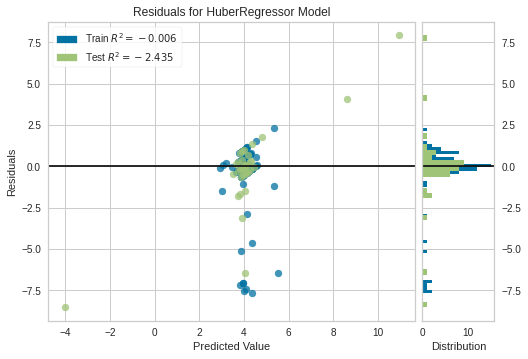

In [7]:
# We can perform some plots to undestand it better
plot_model(tuned_huber)

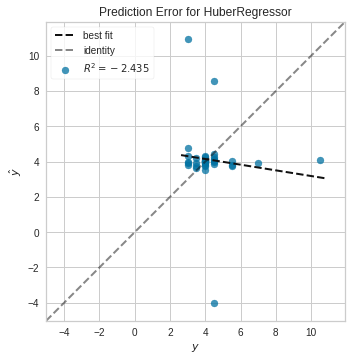

In [8]:
plot_model(tuned_huber, plot = 'error')

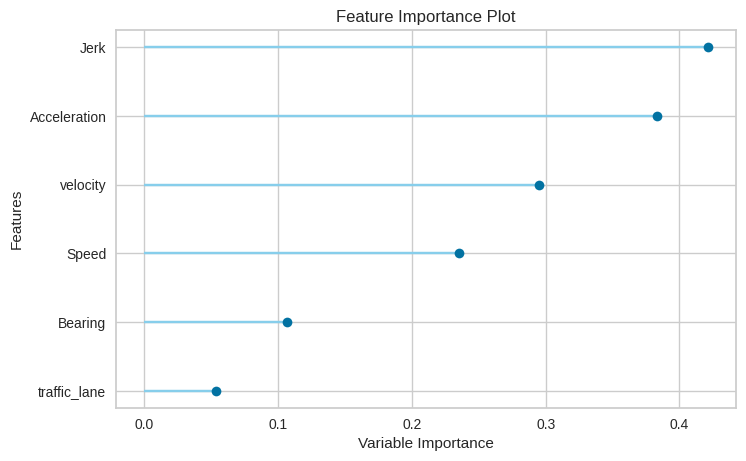

In [9]:
plot_model(tuned_huber, plot='feature')